In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, pairwise_distances
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import nltk
from hazm import Normalizer, word_tokenize, stopwords_list, Stemmer, Lemmatizer
from nltk import FreqDist, word_tokenize
import warnings
import requests
from bs4 import BeautifulSoup
from bidi.algorithm import get_display
from arabic_reshaper import reshape
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances

warnings.filterwarnings("ignore")
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LEGION\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Crawl

In [2]:
def crawl_category(url, category):
    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')

        titles = []
        timestamps = []
        contents = []

        news_items = soup.find_all('li', class_='news')
        news_items = news_items[:2000]

        for news_item in news_items:
            title = news_item.find('h3').get_text(strip=True)
            content = news_item.find('div', class_='desc').get_text(strip=True)

            titles.append(category)
            contents.append(content)

        df_category = pd.DataFrame({'Category': titles, 'Content': contents})

        return df_category
    else:
        print(f"Failed to retrieve the page. Status code: {response.status_code}")
        return None

In [3]:
category_urls = {
    'https://www.hamshahrionline.ir/service/Economy': 'Economy',
    'https://www.hamshahrionline.ir/service/Culture': 'Science and Culture',
    'https://www.hamshahrionline.ir/service/Sport': 'Sport',
    'https://www.hamshahrionline.ir/service/Iran': 'Politics',
}

df_all = pd.DataFrame()

In [4]:
for url, category in category_urls.items():
    df_category = crawl_category(url, category)
    
    if df_category is not None:
        df_all = pd.concat([df_all, df_category], ignore_index=True)

In [2]:
train = pd.read_csv('selected_train_data.csv')
test = pd.read_csv('selected_test_data.csv')

In [3]:
train.info

<bound method DataFrame.info of     category                                               text
0    Economy  \nتحليل بازار \nسرعت گرفتن تحولات جنوب شرق آسي...
1    Economy  \nافزايش بي سابقه مازاد تجاري فرانسه و \nايجاد...
2    Economy  \nتغييرات شاخص هاي اقتصادي در سال 30فاصله \n( ...
3    Economy  \nتغييرات قيمت سهام در بورس تهران \nگروه اقتصا...
4    Economy  \nبهره برداري از طرح توسعه شركت \nسرمايه گذاري...
..       ...                                                ...
795    Sport  \nاولين مدال طلا براي تيم \nوزنه برداري جانباز...
796    Sport  \nبرنامه بازيهاي امروز \nمكزيك - آمريكا ساعت 1...
797    Sport  \n(( مجتبي قاسمي ) ) شهردار منطقه ( ) 19 رئيس ...
798    Sport  \n پيروزي به مرحله يك چهارم نهايي رسيد \nفوتبا...
799    Sport  \n باران، بازيهاي ديروز جام يونس شكوري را \nلغ...

[800 rows x 2 columns]>

In [4]:
test.info

<bound method DataFrame.info of                category                                               text
0               Economy  \nوزير نفت امروز وارد كويت مي شود \n. واحد رسا...
1   Science and Culture  \nسفر به ستارگان; از رويا تا واقعيت! \nاگر كسي...
2                 Sport  \nدر 4 وزن اول دستمان از مدال طلا كوتاه \nماند...
3                 Sport  \nخبرهايي از واليبال آغاز تمرينات تيم \nواليبا...
4                 Sport  \nامروز ديدار پاياني واليبال حذفي تهران \nگروه...
5                 Sport  \nحالا نوبت آنهاست \nايتاليايي هامنتقدان را شگ...
6   Science and Culture  \nتلاش براي دسترسي به شواهد نحوه شكل گيري \nفر...
7               Economy  \nمديريت انرژي پايين آوردن ارزش هزينه \nنهايي ...
8              Politics  \nجرم سياسي از نگاه نمايندگان مجلس \nگروه سياس...
9   Science and Culture  \nتحليل گفتمان در پژوهش \nروش هاي پوزيتيويست م...
10                Sport  \nمراسم قرعه كشي رقابتهاي فوتبال قهرماني \nبان...
11             Politics  \nاستاندار جديد اصفهان تعيين شد \nهيات دولت

## Create vocabulary

In [5]:
word_counts = train['text'].str.split(expand=True).stack().value_counts()
word_counts.to_csv('vocabulary.txt', header=False, sep='\t')
print("Word counts have been saved to vocabulary.txt")

Word counts have been saved to vocabulary.txt


## Let's plot

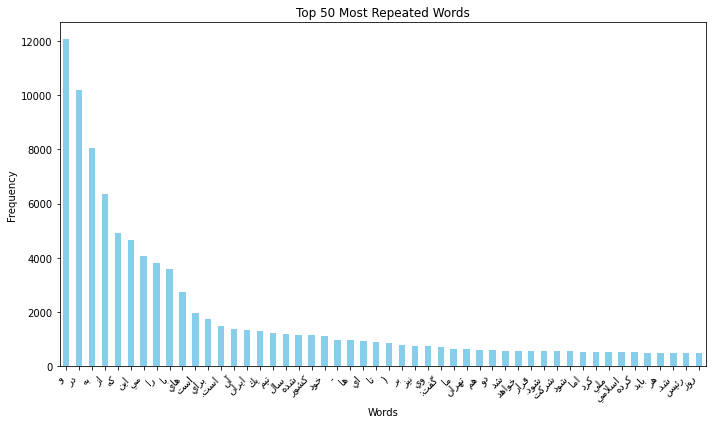

In [6]:
top_words = word_counts.head(50)
reshaped_index = [get_display(reshape(word)) for word in top_words.index]
top_words.index = reshaped_index
plt.figure(figsize=(10, 6))
top_words.plot(kind='bar', color='skyblue')
plt.title('Top 50 Most Repeated Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [7]:
data = train

In [8]:
def normalizer(text):
    normalizer = Normalizer()
    text = normalizer.normalize(text)
    # text = re.sub(r'\u200c', ' ', text)
    # text = re.sub(r'[.,:؛!؟،٫]', '', text)
    # tokens = word_tokenize(text)
    return text

In [9]:
def remove_stopwords(text):
    stop_words = set(stopwords_list())
    tokens = word_tokenize(text)
    filtered_text = ' '.join([token for token in tokens if token.lower() not in stop_words])
    return filtered_text

In [10]:
def lemmatize(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

In [11]:
def apply_stemming(text):
    tokens = word_tokenize(text)
    stemmed_text = ' '.join([stemmer.stem(token) for token in tokens])
    return stemmed_text

## Normalization

In [14]:
train['normalized'] = train['text'].apply(normalizer)
test['normalized'] = test['text'].apply(normalizer)

## Normalization And Removing stopwords

In [15]:
train['stopwords_removed'] = train['normalized'].apply(remove_stopwords)
test['stopwords_removed'] = test['normalized'].apply(remove_stopwords)

## Normalization And Stemming

In [16]:
stemmer = Stemmer()
train['normalizedAndStemmed'] = train['normalized'].apply(apply_stemming)
test['normalizedAndStemmed'] = test['normalized'].apply(apply_stemming)

## Normalization And Stemming And Removing stopwords

In [17]:
normalizer = Normalizer()
stemmer = Stemmer()
train['normalizedAndStemmedAndStopwords'] = train['stopwords_removed'].apply(apply_stemming)
test['normalizedAndStemmedAndStopwords'] = test['stopwords_removed'].apply(apply_stemming)

In [215]:
train

,category,text,normalized,stopwords_removed,normalizedAndStemmed,normalizedAndStemmedAndStopwords
0,Economy,\nتحليل بازار \nسرعت گرفتن تحولات جنوب شرق آسي...,\nتحلیل بازار \nسرعت گرفتن تحولات جنوب شرق آسی...,تحلیل بازار سرعت گرفتن تحولات جنوب شرق آسیا عل...,تحلیل بازار سرع گرفتن تحول جنوب شرق آسیا علیرض...,تحلیل بازار سرع گرفتن تحول جنوب شرق آسیا علیرض...
1,Economy,\nافزايش بي سابقه مازاد تجاري فرانسه و \nايجاد...,\nافزایش بی سابقه مازاد تجاری فرانسه و \nایجاد...,افزایش سابقه مازاد تجاری فرانسه ایجاد مشاغل تا...,افزا ب سابقه مازاد تجار فرانسه و ایجاد مشاغل ت...,افزا سابقه مازاد تجار فرانسه ایجاد مشاغل تازه ...
2,Economy,\nتغييرات شاخص هاي اقتصادي در سال 30فاصله \n( ...,\nتغییرات شاخص‌های اقتصادی در سال ۳۰فاصله \n (...,تغییرات شاخص‌های اقتصادی سال ۳۰ فاصله ( ) ۸۰۱۳...,تغییر شاخص اقتصاد در سال ۳۰ فاصله ( ) ۸۰۱۳۵۰ ق...,تغییر شاخص اقتصاد سال ۳۰ فاصله ( ) ۸۰۱۳۵۰ قیم ...
3,Economy,\nتغييرات قيمت سهام در بورس تهران \nگروه اقتصا...,\nتغییرات قیمت سهام در بورس تهران \nگروه اقتصا...,تغییرات قیمت سهام بورس تهران گروه اقتصادی : دی...,تغییر قیم س در بورس تهر گروه اقتصاد : دیروز در...,تغییر قیم س بورس تهر گروه اقتصاد : دیروز بورس ...
4,Economy,\nبهره برداري از طرح توسعه شركت \nسرمايه گذاري...,\nبهره برداری از طرح توسعه شرکت \nسرمایه گذاری...,بهره طرح توسعه شرکت سرمایه پتروشیمی گروه اقتصا...,بهره بردار از طرح توسعه شرک سرمایه گذار پتروشی...,بهره طرح توسعه شرک سرمایه پتروشیم گروه اقتصاد ...
...,...,...,...,...,...,...
795,Sport,\nاولين مدال طلا براي تيم \nوزنه برداري جانباز...,\nاولین مدال طلا برای تیم \nوزنه برداری جانباز...,مدال طلا تیم وزنه جانبازان ایران معلولان مسابق...,اولین مدال طلا برا ت وزنه بردار جانباز و ایر م...,مدال طلا ت وزنه جانباز ایر معلول مسابق قهرمان ...
796,Sport,\nبرنامه بازيهاي امروز \nمكزيك - آمريكا ساعت 1...,\nبرنامه بازیهای امروز \nمکزیک - آمریکا ساعت ۱...,برنامه بازیهای امروز مکزیک - آمریکا ساعت ۱۱ شه...,برنامه بازی امروز مکزیک - آمریکا ساع ۱۱ در شهر...,برنامه بازی امروز مکزیک - آمریکا ساع ۱۱ شهر جی...
797,Sport,\n(( مجتبي قاسمي ) ) شهردار منطقه ( ) 19 رئيس ...,\n ((مجتبی قاسمی)) شهردار منطقه () ۱۹ رئیس \nه...,( ( مجتبی قاسمی ) ) شهردار منطقه ( ) ۱۹ رئیس ه...,( ( مجتب قاسم ) ) شهردار منطقه ( ) ۱۹ رئیس ه ژ...,( ( مجتب قاسم ) ) شهردار منطقه ( ) ۱۹ رئیس ه ژ...
798,Sport,\n پيروزي به مرحله يك چهارم نهايي رسيد \nفوتبا...,\n پیروزی به مرحله یک چهارم نهایی رسید \nفوتبا...,پیروزی مرحله نهایی فوتبال جام حذفی کشور پیروزی...,پیروز به مرحله یک چهار ن رسید فوتبال جا حذف کش...,پیروز مرحله ن فوتبال جا حذف کشور پیروز پل اکری...


## compare using NearestNeighbors and cosine

In [19]:
all_text = pd.concat([train['text'], test['text']], axis=0)

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(all_text)

tfidf_matrix_train = tfidf_matrix[:len(train)]
tfidf_matrix_test = tfidf_matrix[len(train):]

retriever_configs = {
    'n_neighbors': 10,
    'metric': 'cosine'
}
retriever = NearestNeighbors(**retriever_configs)
retriever.fit(tfidf_matrix_train)

def retrieve_similar_texts(test_index):
    test_vector = tfidf_matrix_test[test_index]
    distances, indices = retriever.kneighbors(test_vector)
    similar_texts = train['text'].iloc[indices[0]].tolist()
    cosine_scores = 1 - distances[0]  
    return similar_texts, cosine_scores

test_index = 8  
similar_texts, cosine_scores = retrieve_similar_texts(test_index)

print(f"Test Text:\n{test['text'].iloc[test_index]}\n")
print(f"Top 5 similar texts and cosine scores for test text {test_index + 1}:\n")
for i, (text, score) in enumerate(zip(similar_texts, cosine_scores), start=1):
    print(f"{i}. {text}\n   Cosine Similarity Score: {score:.4f}\n")

Test Text:

جرم سياسي از نگاه نمايندگان مجلس 
گروه سياسي: در پي ارائه لايحه جرم سياسي به مجلس شوراي 
اسلامي تعدادي از نمايندگان در گفتگو با خبرنگار همشهري 
نظر خود را در مورد تعريف جرم سياسي بيان كردند. 
رجبعلي مزروعي نماينده اصفهان گفت: مجلس بايد مصاديق جرم 
سياسي را مشخص كند تا هر نظر و يا نقدي به عنوان جرم 
سياسي تلقي نشود. 
وي طرح كلي و مبهم مسائل را اشكال اصلي قانونگذاري ذكر 
كرد و گفت: مثلا اصلاحيه قانون مطبوعات انتشار مطلب 
عليه قانون اساسي را ممنوع و جرم اعلام كرده كه اين بند 
از قانون نه شفاف است و نه صراحت دارد و ممكن است شامل 
كساني هم كه به قانون اساسي انتقاد مي كنند بشود. قرباني 
نماينده قائنات و عضو كميسيون قضايي نيز اقدامات 
مسالمت آميزي را كه افراد در ارتباط با نظام انجام 
مي دهند ولي آن اقدامات خلاف قانون است، جرم سياسي دانست. 
وي گفت: امتيازاتي كه براي مجرمان سياسي در نظر گرفته 
مي شود شامل كساني كه مبارزه مسلحانه مي كنند نمي شود. 
احمد شيرزاد رئيس كميسيون آموزش و تحقيقات نيز در تعريف 
جرم سياسي گفت: جرائمي كه به نوعي با افراد و نهادهاي 
سياسي و صاحب فكر مربوط مي شود 

## Edited Metrics for TF-IDF Jaccard and cosine

In [98]:
def calculate_similarity_and_evaluation(train, test, text_column, similarity_threshold=0.7, metric='cosine'):
    all_text = pd.concat([train[text_column], test[text_column]], axis=0)
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
    tfidf_matrix = tfidf_vectorizer.fit_transform(all_text)
    tfidf_matrix_train = tfidf_matrix[:len(train)]
    tfidf_matrix_test = tfidf_matrix[len(train):]

    if metric == 'cosine':
        similarity_matrix = 1 - pairwise_distances(tfidf_matrix_test, tfidf_matrix_train, metric='cosine')
    elif metric == 'jaccard':
        similarity_matrix = np.dot(tfidf_matrix_test, tfidf_matrix_train.T)
        dense_tfidf_matrix_test = tfidf_matrix_test.toarray()
        dense_tfidf_matrix_train = tfidf_matrix_train.toarray()
        norm_test = np.linalg.norm(dense_tfidf_matrix_test, axis=1)
        norm_train = np.linalg.norm(dense_tfidf_matrix_train, axis=1)
        similarity_matrix = similarity_matrix / np.outer(norm_test, norm_train)

    result_df = pd.DataFrame(columns=[f'Test Query in {text_column}',
                                      f'Most Similar Document ({metric.capitalize()} Similarity) in {text_column}',
                                      f'Similarity Score ({metric.capitalize()} Similarity) in {text_column}',
                                      f'Category Match ({metric.capitalize()} Similarity) in {text_column}'])

    for test_index in range(len(test)):
        indices = np.where(similarity_matrix[test_index] > similarity_threshold)[0]
        if len(indices) == 0:
            continue
        
        most_similar_document = train[text_column].iloc[indices[0]]
        similarity_score = similarity_matrix[test_index, indices[0]]

        category_match = int(train['category'].iloc[indices[0]] == test['category'].iloc[test_index])

        result_df = result_df.append({
            f'Test Query in {text_column}': test[text_column].iloc[test_index],
            f'Most Similar Document ({metric.capitalize()} Similarity) in {text_column}': most_similar_document,
            f'Similarity Score ({metric.capitalize()} Similarity) in {text_column}': similarity_score,
            f'Category Match ({metric.capitalize()} Similarity) in {text_column}': category_match
        }, ignore_index=True)

    true_positives = result_df[f'Category Match ({metric.capitalize()} Similarity) in {text_column}'].sum()
    false_positives = len(result_df) - true_positives
    false_negatives = len(test) - true_positives

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    mean_similarity = result_df[f'Similarity Score ({metric.capitalize()} Similarity) in {text_column}'].mean()
    mean_category_match = result_df[f'Category Match ({metric.capitalize()} Similarity) in {text_column}'].mean()

    return result_df, mean_similarity, mean_category_match, precision, recall


In [99]:
def evaluate_with_thresholds(train, test, text_column, column_name, thresholds):
    precisions_cosine = []
    recalls_cosine = []
    precisions_jaccard = []
    recalls_jaccard = []

    for threshold in thresholds:
        _, _, _, precision_cosine, recall_cosine = calculate_similarity_and_evaluation(
            train, test, text_column, similarity_threshold=threshold, metric='cosine'
        )
        precisions_cosine.append(precision_cosine)
        recalls_cosine.append(recall_cosine)

        _, _, _, precision_jaccard, recall_jaccard = calculate_similarity_and_evaluation(
            train, test, text_column, similarity_threshold=threshold, metric='jaccard'
        )
        precisions_jaccard.append(precision_jaccard)
        recalls_jaccard.append(recall_jaccard)

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precisions_cosine, label='Precision (Cosine)', marker='o', linestyle='-', color='blue')
    plt.plot(thresholds, recalls_cosine, label='Recall (Cosine)', marker='o', linestyle='-', color='green')
    plt.plot(thresholds, precisions_jaccard, label='Precision (Jaccard)', marker='o', linestyle='-', color='orange')
    plt.plot(thresholds, recalls_jaccard, label='Recall (Jaccard)', marker='o', linestyle='-', color='red')
    plt.title(f'Precision-Recall Curve for Different Similarity Thresholds ({column_name})')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()


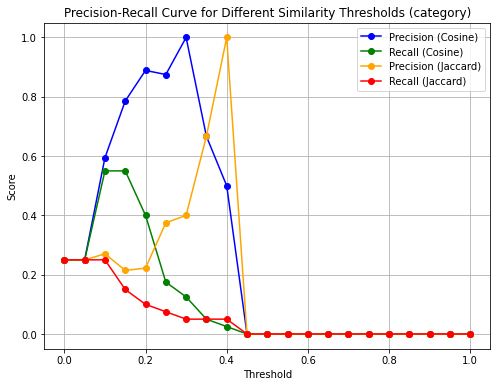

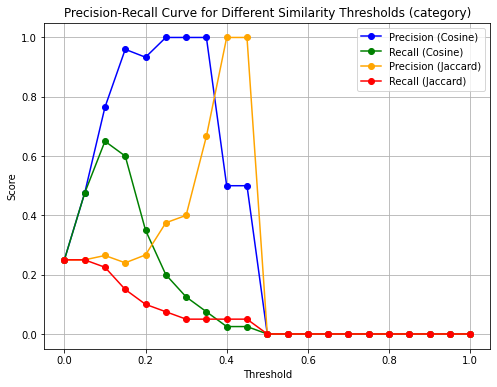

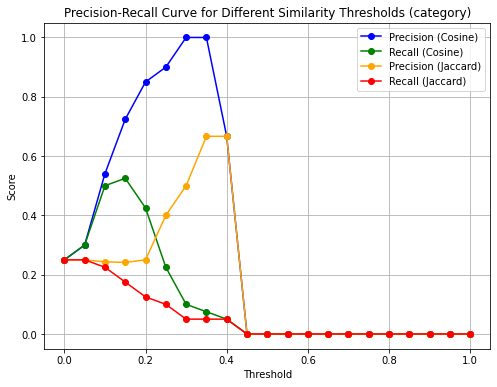

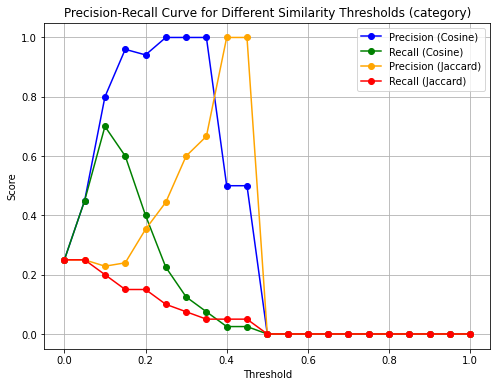

In [100]:
evaluate_with_thresholds(train, test, 'normalized', 'category', thresholds)
evaluate_with_thresholds(train, test, 'stopwords_removed', 'category', thresholds)
evaluate_with_thresholds(train, test, 'normalizedAndStemmed', 'category', thresholds)
evaluate_with_thresholds(train, test, 'normalizedAndStemmedAndStopwords', 'category', thresholds)

## TF-IDF Jaccard and cosine

In [101]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import pairwise_distances
# import pandas as pd

# def calculate_similarity_and_evaluation(train, test, text_column):
#     all_text = pd.concat([train[text_column], test[text_column]], axis=0)
#     tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
#     tfidf_matrix = tfidf_vectorizer.fit_transform(all_text)
#     tfidf_matrix_train = tfidf_matrix[:len(train)]
#     tfidf_matrix_test = tfidf_matrix[len(train):]

#     cosine_similarity_matrix = 1 - pairwise_distances(tfidf_matrix_test, tfidf_matrix_train, metric='cosine')
#     dense_tfidf_matrix_test = tfidf_matrix_test.toarray()
#     dense_tfidf_matrix_train = tfidf_matrix_train.toarray()

#     jaccard_similarity_matrix = 1 - pairwise_distances(dense_tfidf_matrix_test, dense_tfidf_matrix_train, metric='jaccard')

#     result_cosine_df = pd.DataFrame(columns=[f'Test Query in {text_column}',
#                                              f'Most Similar Document (Cosine Similarity) in {text_column}',
#                                              f'Similarity Score (Cosine Similarity) in {text_column}',
#                                              f'Recall (Cosine Similarity) in {text_column}',
#                                              f'Precision (Cosine Similarity) in {text_column}'])

#     for test_index in range(len(test)):
#         indices_cosine = cosine_similarity_matrix[test_index].argsort()[-1:][::-1]
#         most_similar_document_cosine = train[text_column].iloc[indices_cosine[0]]
#         similarity_score_cosine = cosine_similarity_matrix[test_index, indices_cosine][0]

#         precision_cosine = int(train['category'].iloc[indices_cosine[0]] == test['category'].iloc[test_index])
#         recall_cosine = precision_cosine  

#         result_cosine_df = result_cosine_df.append({
#             f'Test Query in {text_column}': test[text_column].iloc[test_index],
#             f'Most Similar Document (Cosine Similarity) in {text_column}': most_similar_document_cosine,
#             f'Similarity Score (Cosine Similarity) in {text_column}': similarity_score_cosine,
#             f'Recall (Cosine Similarity) in {text_column}': recall_cosine,
#             f'Precision (Cosine Similarity) in {text_column}': precision_cosine
#         }, ignore_index=True)

#     result_jaccard_df = pd.DataFrame(columns=[f'Test Query in {text_column}',
#                                               f'Most Similar Document (Jaccard Similarity) in {text_column}',
#                                               f'Similarity Score (Jaccard Similarity) in {text_column}',
#                                               f'Recall (Jaccard Similarity) in {text_column}',
#                                               f'Precision (Jaccard Similarity) in {text_column}'])

#     for test_index in range(len(test)):
#         indices_jaccard = jaccard_similarity_matrix[test_index].argsort()[-1:][::-1]
#         most_similar_document_jaccard = train[text_column].iloc[indices_jaccard[0]]
#         similarity_score_jaccard = jaccard_similarity_matrix[test_index, indices_jaccard][0]

#         precision_jaccard = int(train['category'].iloc[indices_jaccard[0]] == test['category'].iloc[test_index])
#         recall_jaccard = precision_jaccard

#         result_jaccard_df = result_jaccard_df.append({
#             f'Test Query in {text_column}': test[text_column].iloc[test_index],
#             f'Most Similar Document (Jaccard Similarity) in {text_column}': most_similar_document_jaccard,
#             f'Similarity Score (Jaccard Similarity) in {text_column}': similarity_score_jaccard,
#             f'Recall (Jaccard Similarity) in {text_column}': recall_jaccard,
#             f'Precision (Jaccard Similarity) in {text_column}': precision_jaccard
#         }, ignore_index=True)

#     # Calculate mean of the columns for both result DataFrames
#     mean_cosine_similarity = result_cosine_df[f'Similarity Score (Cosine Similarity) in {text_column}'].mean()
#     mean_jaccard_similarity = result_jaccard_df[f'Similarity Score (Jaccard Similarity) in {text_column}'].mean()
#     mean_precision_cosine = result_cosine_df[f'Precision (Cosine Similarity) in {text_column}'].mean()
#     mean_recall_cosine = result_cosine_df[f'Recall (Cosine Similarity) in {text_column}'].mean()
#     mean_precision_jaccard = result_jaccard_df[f'Precision (Jaccard Similarity) in {text_column}'].mean()
#     mean_recall_jaccard = result_jaccard_df[f'Recall (Jaccard Similarity) in {text_column}'].mean()

#     return (
#         result_cosine_df,
#         result_jaccard_df,
#         mean_cosine_similarity,
#         mean_jaccard_similarity,
#         mean_precision_cosine,
#         mean_recall_cosine,
#         mean_precision_jaccard,
#         mean_recall_jaccard
#     )

In [102]:
# train.columns

In [103]:
# result_cosine_normalized, result_jaccard_normalized, mean_cosine_normalized , mean_jaccard_normalized, mean_precision_cosine_normalized, mean_recall_cosine_normalized,  mean_precision_jaccard_normalized, mean_recall_jaccard_normalized,   = calculate_similarity_and_evaluation(train, test, 'normalized')
# result_cosine_stopwords_removed, result_jaccard_stopwords_removed, mean_cosine_stopwords_removed, mean_jaccard_stopwords_removed, mean_precision_cosine_stopwords_removed, mean_recall_cosine_stopwords_removed, mean_precision_jaccard_stopwords_removed, mean_recall_jaccard_stopwords_removed = calculate_similarity_and_evaluation(train, test, 'stopwords_removed')
# result_cosine_normalizedAndStemmed, result_jaccard_normalizedAndStemmed, mean_cosine_normalizedAndStemmed, mean_jaccard_normalizedAndStemmed, mean_precision_cosine_normalizedAndStemmed, mean_recall_cosine_normalizedAndStemmed, mean_precision_jaccard_normalizedAndStemmed, mean_recall_jaccard_normalizedAndStemmed = calculate_similarity_and_evaluation(train, test, 'normalizedAndStemmed')
# result_cosine_normalizedAndStemmedAndStopwords, result_jaccard_normalizedAndStemmedAndStopwords, mean_cosine_normalizedAndStemmedAndStopwords, mean_jaccard_normalizedAndStemmedAndStopwords, mean_precision_cosine_normalizedAndStemmedAndStopwords, mean_recall_cosine_normalizedAndStemmedAndStopwords, mean_precision_jaccard_normalizedAndStemmedAndStopwords, mean_recall_jaccard_normalizedAndStemmedAndStopwords = calculate_similarity_and_evaluation(train, test, 'normalizedAndStemmedAndStopwords')

In [104]:
# means_table = pd.DataFrame({
#     'Preprocessing Method': ['Normalized', 'Stopwords Removed', 'Normalized and Stemmed', 'Normalized, Stemmed, and Stopwords'],
#     'Mean Cosine Similarity': [mean_cosine_normalized, mean_cosine_stopwords_removed, mean_cosine_normalizedAndStemmed, mean_cosine_normalizedAndStemmedAndStopwords],
#     'Mean Jaccard Similarity': [mean_jaccard_normalized, mean_jaccard_stopwords_removed, mean_jaccard_normalizedAndStemmed, mean_jaccard_normalizedAndStemmedAndStopwords]
# })
# means_table

In [105]:
# precision_recall_means = pd.DataFrame(columns=['Text Column', 'Mean Precision (Cosine)', 'Mean Recall (Cosine)', 'Mean Precision (Jaccard)', 'Mean Recall (Jaccard)'])

# precision_recall_means = precision_recall_means.append({
#     'Text Column': 'Normalized',
#     'Mean Precision (Cosine)': mean_precision_cosine_normalized,
#     'Mean Recall (Cosine)': mean_recall_cosine_normalized,
#     'Mean Precision (Jaccard)': mean_precision_jaccard_normalized,
#     'Mean Recall (Jaccard)': mean_recall_jaccard_normalized
# }, ignore_index=True)

# precision_recall_means = precision_recall_means.append({
#     'Text Column': 'Stopwords Removed',
#     'Mean Precision (Cosine)': mean_precision_cosine_stopwords_removed,
#     'Mean Recall (Cosine)': mean_recall_cosine_stopwords_removed,
#     'Mean Precision (Jaccard)': mean_precision_jaccard_stopwords_removed,
#     'Mean Recall (Jaccard)': mean_recall_jaccard_stopwords_removed
# }, ignore_index=True)

# precision_recall_means = precision_recall_means.append({
#     'Text Column': 'Normalized and Stemmed',
#     'Mean Precision (Cosine)': mean_precision_cosine_normalizedAndStemmed,
#     'Mean Recall (Cosine)': mean_recall_cosine_normalizedAndStemmed,
#     'Mean Precision (Jaccard)': mean_precision_jaccard_normalizedAndStemmed,
#     'Mean Recall (Jaccard)': mean_recall_jaccard_normalizedAndStemmed
# }, ignore_index=True)

# precision_recall_means = precision_recall_means.append({
#     'Text Column': 'Normalized, Stemmed, and Stopwords Removed',
#     'Mean Precision (Cosine)': mean_precision_cosine_normalizedAndStemmedAndStopwords,
#     'Mean Recall (Cosine)': mean_recall_cosine_normalizedAndStemmedAndStopwords,
#     'Mean Precision (Jaccard)': mean_precision_jaccard_normalizedAndStemmedAndStopwords,
#     'Mean Recall (Jaccard)': mean_recall_jaccard_normalizedAndStemmedAndStopwords
# }, ignore_index=True)

# precision_recall_means

In [106]:
# result_cosine_normalized.head()

In [107]:
# result_jaccard_normalized.head()

In [108]:
# result_cosine_normalizedAndStemmedAndStopwords.head()

## Bert cosine and jaccard

In [65]:
# def calculate_similarity_and_evaluation_bert(train, test, text_column):
#     all_text = pd.concat([train[text_column], test[text_column]], axis=0)
#     model_path = r'C:\Users\LEGION\.cache\torch\sentence_transformers\sentence-transformers_LaBSE'
#     model = SentenceTransformer(model_path)
#     embeddings = model.encode(all_text.tolist(), convert_to_tensor=True)
#     embeddings_train = embeddings[:len(train)]
#     embeddings_test = embeddings[len(train):]
#     cosine_similarity_matrix = cosine_similarity(embeddings_test, embeddings_train)
#     dense_embeddings_test = embeddings_test.cpu().numpy()
#     dense_embeddings_train = embeddings_train.cpu().numpy()
#     jaccard_similarity_matrix = 1 - pairwise_distances(dense_embeddings_test, dense_embeddings_train, metric='cosine')
    
#     result_cosine_df = pd.DataFrame(columns=[f'Test Query in {text_column}',
#                                              f'Most Similar Document (Cosine Similarity) in {text_column}',
#                                              f'Similarity Score (Cosine Similarity) in {text_column}',
#                                              f'Recall (Cosine Similarity) in {text_column}',
#                                              f'Precision (Cosine Similarity) in {text_column}'])

#     for test_index in range(len(test)):
#         indices_cosine = cosine_similarity_matrix[test_index].argsort()[-1:][::-1]
#         most_similar_document_cosine = train[text_column].iloc[indices_cosine[0]]
#         similarity_score_cosine = cosine_similarity_matrix[test_index, indices_cosine][0]
#         precision_cosine = int(train['category'].iloc[indices_cosine[0]] == test['category'].iloc[test_index])
#         recall_cosine = precision_cosine  
#         result_cosine_df = result_cosine_df.append({
#             f'Test Query in {text_column}': test[text_column].iloc[test_index],
#             f'Most Similar Document (Cosine Similarity) in {text_column}': most_similar_document_cosine,
#             f'Similarity Score (Cosine Similarity) in {text_column}': similarity_score_cosine,
#             f'Recall (Cosine Similarity) in {text_column}': recall_cosine,
#             f'Precision (Cosine Similarity) in {text_column}': precision_cosine
#         }, ignore_index=True)

#     # Calculate mean of the "Similarity Score (Cosine Similarity)", "Precision", and "Recall" columns
#     mean_cosine_similarity = result_cosine_df[f'Similarity Score (Cosine Similarity) in {text_column}'].mean()
#     mean_precision_cosine = result_cosine_df[f'Precision (Cosine Similarity) in {text_column}'].mean()
#     mean_recall_cosine = result_cosine_df[f'Recall (Cosine Similarity) in {text_column}'].mean()

#     result_jaccard_df = pd.DataFrame(columns=[f'Test Query in {text_column}',
#                                               f'Most Similar Document (Jaccard Similarity) in {text_column}',
#                                               f'Similarity Score (Jaccard Similarity) in {text_column}',
#                                               f'Recall (Jaccard Similarity) in {text_column}',
#                                               f'Precision (Jaccard Similarity) in {text_column}'])

#     for test_index in range(len(test)):
#         indices_jaccard = jaccard_similarity_matrix[test_index].argsort()[-1:][::-1]
#         most_similar_document_jaccard = train[text_column].iloc[indices_jaccard[0]]
#         similarity_score_jaccard = jaccard_similarity_matrix[test_index, indices_jaccard][0]
#         precision_jaccard = int(train['category'].iloc[indices_jaccard[0]] == test['category'].iloc[test_index])
#         recall_jaccard = precision_jaccard  

#         result_jaccard_df = result_jaccard_df.append({
#             f'Test Query in {text_column}': test[text_column].iloc[test_index],
#             f'Most Similar Document (Jaccard Similarity) in {text_column}': most_similar_document_jaccard,
#             f'Similarity Score (Jaccard Similarity) in {text_column}': similarity_score_jaccard,
#             f'Recall (Jaccard Similarity) in {text_column}': recall_jaccard,
#             f'Precision (Jaccard Similarity) in {text_column}': precision_jaccard
#         }, ignore_index=True)

#     # Calculate mean of the "Similarity Score (Jaccard Similarity)", "Precision", and "Recall" columns
#     mean_jaccard_similarity = result_jaccard_df[f'Similarity Score (Jaccard Similarity) in {text_column}'].mean()
#     mean_precision_jaccard = result_jaccard_df[f'Precision (Jaccard Similarity) in {text_column}'].mean()
#     mean_recall_jaccard = result_jaccard_df[f'Recall (Jaccard Similarity) in {text_column}'].mean()

#     return result_cosine_df, result_jaccard_df, mean_cosine_similarity, mean_precision_cosine, mean_recall_cosine, mean_jaccard_similarity, mean_precision_jaccard, mean_recall_jaccard


In [67]:
# result_cosine_normalized_bert, result_jaccard_normalized_bert, mean_cosine_normalized_bert, mean_jaccard_normalized_bert, mean_precision_cosine_normalized_bert, mean_recall_cosine_normalized_bert, mean_precision_jaccard_normalized_bert, mean_recall_jaccard_normalized_bert = calculate_similarity_and_evaluation_bert(train, test, 'normalized')
# result_cosine_stopwords_removed_bert, result_jaccard_stopwords_removed_bert, mean_cosine_stopwords_removed_bert, mean_jaccard_stopwords_removed_bert, mean_precision_cosine_stopwords_removed_bert, mean_recall_cosine_stopwords_removed_bert, mean_precision_jaccard_stopwords_removed_bert, mean_recall_jaccard_stopwords_removed_bert = calculate_similarity_and_evaluation_bert(train, test, 'stopwords_removed')
# result_cosine_normalizedAndStemmed_bert, result_jaccard_normalizedAndStemmed_bert, mean_cosine_normalizedAndStemmed_bert, mean_jaccard_normalizedAndStemmed_bert, mean_precision_cosine_normalizedAndStemmed_bert, mean_recall_cosine_normalizedAndStemmed_bert, mean_precision_jaccard_normalizedAndStemmed_bert, mean_recall_jaccard_normalizedAndStemmed_bert = calculate_similarity_and_evaluation_bert(train, test, 'normalizedAndStemmed')
# result_cosine_normalizedAndStemmedAndStopwords_bert, result_jaccard_normalizedAndStemmedAndStopwords_bert, mean_cosine_normalizedAndStemmedAndStopwords_bert, mean_jaccard_normalizedAndStemmedAndStopwords_bert, mean_precision_cosine_normalizedAndStemmedAndStopwords_bert, mean_recall_cosine_normalizedAndStemmedAndStopwords_bert, mean_precision_jaccard_normalizedAndStemmedAndStopwords_bert, mean_recall_jaccard_normalizedAndStemmedAndStopwords_bert = calculate_similarity_and_evaluation_bert(train, test, 'normalizedAndStemmedAndStopwords')

In [68]:
# data = {
#     'Method': ['normalized', 'stopwords_removed', 'normalizedAndStemmed', 'normalizedAndStemmedAndStopwords'],
#     'Mean_Cosine': [
#         mean_cosine_normalized_bert, mean_cosine_stopwords_removed_bert,
#         mean_cosine_normalizedAndStemmed_bert, mean_cosine_normalizedAndStemmedAndStopwords_bert
#     ],
#     'Mean_Jaccard': [
#         mean_jaccard_normalized_bert, mean_jaccard_stopwords_removed_bert,
#         mean_jaccard_normalizedAndStemmed_bert, mean_jaccard_normalizedAndStemmedAndStopwords_bert
#     ]
# }

# mean_df = pd.DataFrame(data)
# mean_df

,Method,Mean_Cosine,Mean_Jaccard
0,normalized,0.686034,0.85
1,stopwords_removed,0.721481,0.90
2,normalizedAndStemmed,0.689935,0.85
3,normalizedAndStemmedAndStopwords,0.725233,0.90


In [69]:
# precision_recall_data = {
#     'Method': ['normalized', 'stopwords_removed', 'normalizedAndStemmed', 'normalizedAndStemmedAndStopwords'],
#     'Mean_Precision': [
#         mean_precision_cosine_normalized_bert, mean_precision_cosine_stopwords_removed_bert,
#         mean_precision_cosine_normalizedAndStemmed_bert, mean_precision_cosine_normalizedAndStemmedAndStopwords_bert
#     ],
#     'Mean_Recall': [
#         mean_recall_cosine_normalized_bert, mean_recall_cosine_stopwords_removed_bert,
#         mean_recall_cosine_normalizedAndStemmed_bert, mean_recall_cosine_normalizedAndStemmedAndStopwords_bert
#     ]
# }

# precision_recall_df = pd.DataFrame(precision_recall_data)
# precision_recall_df

,Method,Mean_Precision,Mean_Recall
0,normalized,0.85,0.686034
1,stopwords_removed,0.90,0.721481
2,normalizedAndStemmed,0.85,0.689935
3,normalizedAndStemmedAndStopwords,0.90,0.725233


In [51]:
# result_cosine_normalizedAndStemmedAndStopwords_bert.head()

,Test Query in normalizedAndStemmedAndStopwords,Most Similar Document (Cosine Similarity) in normalizedAndStemmedAndStopwords,Similarity Score (Cosine Similarity) in normalizedAndStemmedAndStopwords,Recall (Cosine Similarity) in normalizedAndStemmedAndStopwords,Precision (Cosine Similarity) in normalizedAndStemmedAndStopwords
0,وزیر نف امروز کو . واحد رسانه خارج همشهر : غلا...,تیمسار لطف : نوپو تهاج کو دانشگاه دخال ندا پرس...,0.130069,0,0
1,سفر ستارگان; رویا واقع ! بپرسد : سرانجا موفق س...,مدیر بحر انرژ ؟ چیس دک امیر عباس صدیق ، دکترا ...,0.122169,1,1
2,۴ وزن دس مدال طلا کوتاه ماند کشت فرنگ قهرمان آ...,ت کشت دانشجو ایر قهر جا دوگل فرانسه گروه ورزش ...,0.361705,1,1
3,خبر والیبال آغاز تمرین ت والیبال امید گروه ورز...,بازیکن ۲۵ اردو ت مل والیبال ایر گروه ورزش : ار...,0.232968,1,1
4,امروز دیدار پایان والیبال حذف تهر گروه ورزش : ...,والیبال جا بر باشگاه ایر باز پیک - بازیاف ک ۴۸...,0.233586,1,1


## Edited Metric Bert cosine

In [113]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_similarity_and_evaluation_bert(train, test, text_column, similarity_threshold=0.7):
    all_text = pd.concat([train[text_column], test[text_column]], axis=0)
    model_path = r'C:\Users\LEGION\.cache\torch\sentence_transformers\sentence-transformers_LaBSE'
    model = SentenceTransformer(model_path)
    embeddings = model.encode(all_text.tolist(), convert_to_tensor=True)
    embeddings_train = embeddings[:len(train)]
    embeddings_test = embeddings[len(train):]
    cosine_similarity_matrix = cosine_similarity(embeddings_test, embeddings_train)
    dense_embeddings_test = embeddings_test.cpu().numpy()
    dense_embeddings_train = embeddings_train.cpu().numpy()
    
    result_cosine_df = pd.DataFrame(columns=[f'Test Query in {text_column}',
                                             f'Most Similar Document (Cosine Similarity) in {text_column}',
                                             f'Similarity Score (Cosine Similarity) in {text_column}',
                                             f'Category Match (Cosine Similarity) in {text_column}'])

    for test_index in range(len(test)):
        indices_cosine = np.where(cosine_similarity_matrix[test_index] > similarity_threshold)[0]
        if len(indices_cosine) == 0:
            # No document above the threshold
            continue
        
        most_similar_document_cosine = train[text_column].iloc[indices_cosine[0]]
        similarity_score_cosine = cosine_similarity_matrix[test_index, indices_cosine][0]
        category_match_cosine = int(train['category'].iloc[indices_cosine[0]] == test['category'].iloc[test_index])

        result_cosine_df = result_cosine_df.append({
            f'Test Query in {text_column}': test[text_column].iloc[test_index],
            f'Most Similar Document (Cosine Similarity) in {text_column}': most_similar_document_cosine,
            f'Similarity Score (Cosine Similarity) in {text_column}': similarity_score_cosine,
            f'Category Match (Cosine Similarity) in {text_column}': category_match_cosine
        }, ignore_index=True)

    true_positives = result_cosine_df[f'Category Match (Cosine Similarity) in {text_column}'].sum()
    false_positives = len(result_cosine_df) - true_positives
    false_negatives = len(test) - true_positives

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    mean_cosine_similarity = result_cosine_df[f'Similarity Score (Cosine Similarity) in {text_column}'].mean()
    mean_category_match_cosine = result_cosine_df[f'Category Match (Cosine Similarity) in {text_column}'].mean()

    return (
        result_cosine_df,
        mean_cosine_similarity,
        mean_category_match_cosine,
        precision,
        recall
    )


Thresholds: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [08:32<00:00, 170.68s/it]


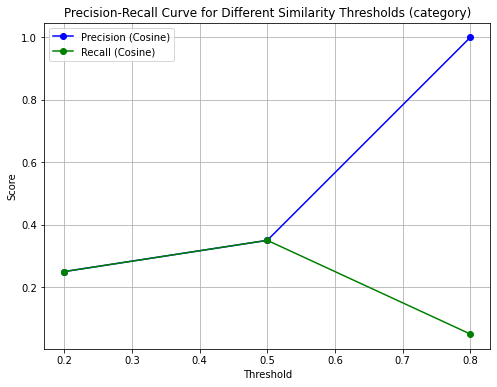

In [116]:
from tqdm import tqdm

def evaluate_with_thresholds_bert(train, test, text_column, column_name, thresholds):
    precisions_cosine = []
    recalls_cosine = []

    for threshold in tqdm(thresholds, desc="Thresholds"):
        _, _, _, precision_cosine, recall_cosine = calculate_similarity_and_evaluation_bert(
            train, test, text_column, similarity_threshold=threshold
        )
        precisions_cosine.append(precision_cosine)
        recalls_cosine.append(recall_cosine)

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precisions_cosine, label='Precision (Cosine)', marker='o', linestyle='-', color='blue')
    plt.plot(thresholds, recalls_cosine, label='Recall (Cosine)', marker='o', linestyle='-', color='green')
    plt.title(f'Precision-Recall Curve for Different Similarity Thresholds ({column_name})')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()


thresholds = [0.2, 0.5, 0.8]
evaluate_with_thresholds_bert(train, test, 'normalized', 'category', thresholds)

Thresholds: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [08:18<00:00, 166.20s/it]


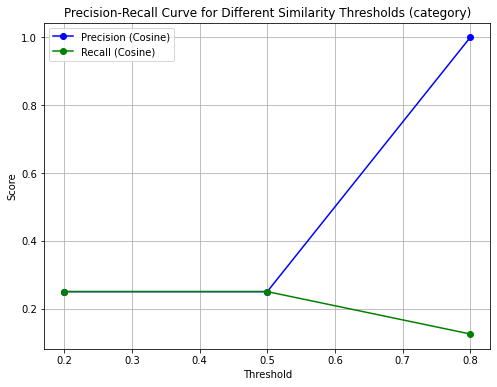

Thresholds: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [08:58<00:00, 179.51s/it]


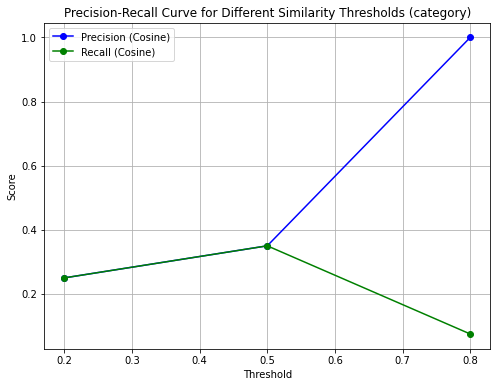

Thresholds: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [08:14<00:00, 164.73s/it]


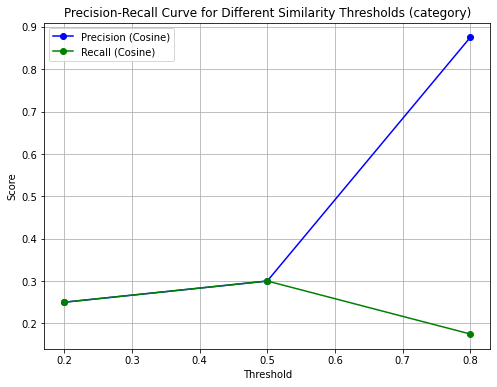

In [118]:
evaluate_with_thresholds_bert(train, test, 'stopwords_removed', 'category', thresholds)
evaluate_with_thresholds_bert(train, test, 'normalizedAndStemmed', 'category', thresholds)
evaluate_with_thresholds_bert(train, test, 'normalizedAndStemmedAndStopwords', 'category', thresholds)